In [1]:
using Plots
using Distributions
using LinearAlgebra
using Statistics

In [131]:
μ₁ = [-5,-7]
Σ₁ = [5 1.44; 1.44 5]

μ₂ = [7,2]
Σ₂ = [5 1; 1 5]

println(isposdef(Σ₁))
println(isposdef(Σ₂))

mixture = MixtureModel(MvNormal, [(μ₁, Σ₁), (μ₂, Σ₂)],[0.3, 0.7])
N = 1000
data = rand(mixture,N)

true
true


2×1000 Array{Float64,2}:
 2.93619  8.96245  -7.39378  5.65986  10.2336   …  6.75562  7.63854  -3.66124
 2.51241  3.14582  -8.51726  3.4203    4.93202     4.0275   4.12821  -5.43812

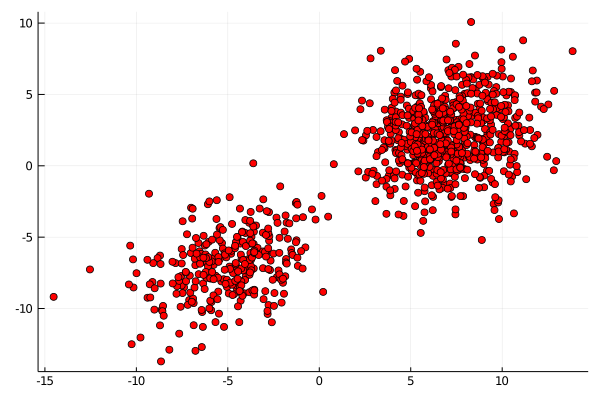

In [132]:
Plots.scatter(data[1,:], data[2,:], color="red", legend=false)

In [133]:
tol = 1e-4

random_mean = Product(Uniform.([-10 for i in 1:2], [10 for i in 1:2]))
est_λ₁ = 0.7
est_λ₂ = 0.3
est_μ₁ = rand(random_mean,1)[:,1] # a guess
est_μ₂ = rand(random_mean,1)[:,1] # another guess
est_Σ₁ = Matrix(1.0I,2,2)
est_Σ₂ = Matrix(1.0I,2,2)

function log_likelihood(μ₁,μ₂,Σ₁,Σ₂,λ₁,λ₂,ws₁,ws₂,data)
    sum(ws₁ .* log.((pdf(MvNormal(μ₁, Σ₁), data) .* λ₁)./ ws₁))  + 
            sum(ws₂ .* log.((pdf(MvNormal(μ₂, Σ₂), data) .* λ₂)./ ws₂))
end

function E_step(μ₁,μ₂,Σ₁,Σ₂,λ₁,λ₂,data)
    ws₁_xz = pdf(MvNormal(μ₁, Σ₁), data) .* λ₁; 
    ws₂_xz = pdf(MvNormal(μ₂, Σ₂), data) .* λ₂;
    ws₁ = ws₁_xz ./ (ws₁_xz + ws₂_xz);
    ws₂ = ws₂_xz ./ (ws₁_xz + ws₂_xz);
    return ws₁, ws₂
end

function M_step(μ₁,μ₂,Σ₁,Σ₂,λ₁,λ₂,ws₁,ws₂,data)
    μ₁_temp = sum(ws₁' .* data, dims=2) / sum(ws₁)
    μ₂_temp = sum(ws₂' .* data, dims=2) / sum(ws₂)
    
    vec1 = sqrt.(ws₁)' .* (data .- μ₁)
    vec2 = sqrt.(ws₂)' .* (data .- μ₂)
    
    Σ₁ = ( vec1 * vec1' ) ./ sum(ws₁)
    Σ₂ = ( vec2 * vec2' ) ./ sum(ws₂)
    
    μ₁ = μ₁_temp[:,1]
    μ₂ = μ₂_temp[:,1]
    
    λ₁ = sum(ws₁)/N
    λ₂ = sum(ws₂)/N
    
    return μ₁, μ₂, Σ₁, Σ₂, λ₁, λ₂
end

M_step (generic function with 1 method)

In [134]:
# Draw Ellipse of Covariance Matrix
# https://cookierobotics.com/007/
tvec = range(0, 2π, length=100)

function parametric_fcn(Σ, μ)
    eigval = eigvals(Σ); eigvec = eigvecs(Σ);
    v1x = eigvec[1,1]; v2x = eigvec[1,2]; v1y = eigvec[2,1]; v2y = eigvec[2,2];
    α = sqrt(5.991) 
    X(t) = α * ( v1x * sqrt(eigval[1]) * cos.(t)  + v2x * sqrt(eigval[2]) * sin.(t) ) .+ μ[1]
    Y(t) = α * ( v1y * sqrt(eigval[1]) * cos.(t)  + v2y * sqrt(eigval[2]) * sin.(t) ) .+ μ[2]
    return X, Y
end

function plot_ellipse(Σ₁, μ₁, Σ₂, μ₂, color₁, color₂)
    X₁, Y₁ = parametric_fcn(Σ₁, μ₁)
    X₂, Y₂ = parametric_fcn(Σ₂, μ₂)
    Plots.scatter(data[1,:], data[2,:], color="red", legend=false)
    plot!(X₁(tvec), Y₁(tvec), color=color₁, xlims = (-15,15), ylims=(-15,15))
    plot!(X₂(tvec), Y₂(tvec), color=color₂, xlims = (-15,15), ylims=(-15,15))
    Plots.frame(anim)
end

plot_ellipse (generic function with 4 methods)

In [135]:

prev_ll = -Inf
ll = 0
iter = 1

anim = Plots.Animation()
# while abs(prev_ll - ll) > tol
for i = 1:50

    ws₁, ws₂ = E_step(est_μ₁,est_μ₂,est_Σ₁,est_Σ₂,est_λ₁,est_λ₂,data);
        
    prev_ll = iter==1 ? prev_ll : ll;

    ll = log_likelihood(est_μ₁,est_μ₂,est_Σ₁,est_Σ₂,est_λ₁,est_λ₂,ws₁,ws₂,data);
    
    est_μ₁, est_μ₂, est_Σ₁, est_Σ₂, est_λ₁, est_λ₂ = M_step(est_μ₁,est_μ₂,est_Σ₁,est_Σ₂,est_λ₁,est_λ₂,ws₁,ws₂,data);

    println("iteration: ", iter, ", log-likelihood: ", ll);
    
    iter += 1;
    plot_ellipse(est_Σ₁, est_μ₁, est_Σ₂, est_μ₂, "red", "blue");
    
    if abs(prev_ll - ll) < tol
        break
    end
end

iteration: 1, log-likelihood: -43498.11309710351
iteration: 2, log-likelihood: -5804.302040411788
iteration: 3, log-likelihood: -5283.718868146543
iteration: 4, log-likelihood: -5251.009357217623
iteration: 5, log-likelihood: -5231.822617800188
iteration: 6, log-likelihood: -5217.426972929348
iteration: 7, log-likelihood: -5203.152634734464
iteration: 8, log-likelihood: -5185.250362299551
iteration: 9, log-likelihood: -5158.530782072341
iteration: 10, log-likelihood: -5120.172954223266
iteration: 11, log-likelihood: -5084.159215735119
iteration: 12, log-likelihood: -5074.096615516039
iteration: 13, log-likelihood: -5073.789797787382
iteration: 14, log-likelihood: -5073.787551464642
iteration: 15, log-likelihood: -5073.787535335588


┌ Info: Saved animation to 
│   fn = /home/shane/Desktop/julia/Untitled Folder/tutorial_anim_fps30.gif
└ @ Plots /home/shane/.julia/packages/Plots/E3MWZ/src/animation.jl:104


Plots.AnimatedGif("/home/shane/Desktop/julia/Untitled Folder/tutorial_anim_fps30.gif")
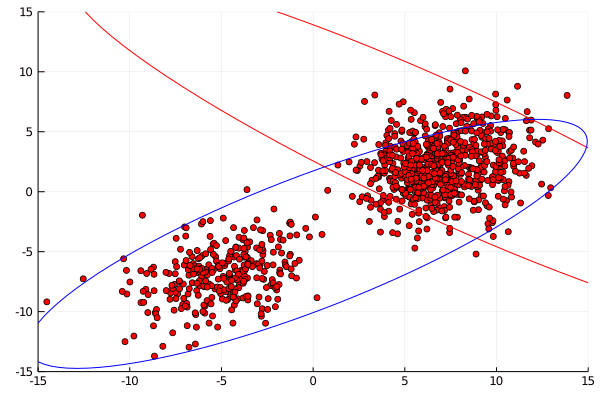

In [136]:
gif(anim, "tutorial_anim_fps30.gif", fps = 2)